<a href="https://colab.research.google.com/github/ksdkamesh99/LowLightEnhancer/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content/drive/My Drive/LowLightEnhancement

/content/drive/My Drive/LowLightEnhancement


In [2]:
import tensorflow as tf
import keras
import numpy as np
from PIL import Image

In [3]:
img_high=np.load("image_high.npy")

In [4]:
img_low=np.load("image_low.npy")

In [5]:
img_high.shape

(1485, 150, 150, 3)

## Illumination Mask Network

In [6]:
input_layer_1=keras.layers.Input(shape=(150,150,3))

In [7]:
top=keras.layers.Conv2D(64,kernel_size=(3,3),input_shape=(150,150,3),activation='relu')(input_layer_1)
top=keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(top)

In [8]:
bottom_inp=input_layer_1
bottom_resize=keras.layers.experimental.preprocessing.Resizing(224,224)(bottom_inp)


In [9]:
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),input_shape=(224,224,3),activation='relu')(bottom_resize)
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(bottom)
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(bottom)
bottom=keras.layers.experimental.preprocessing.Resizing(146,146)(bottom)

In [10]:
bottom.get_shape()

TensorShape([None, 146, 146, 64])

In [11]:
top.get_shape()

TensorShape([None, 146, 146, 64])

In [12]:
merged=keras.layers.concatenate([top,bottom],axis=-1)

In [13]:
merged

<tf.Tensor 'concatenate/concat:0' shape=(None, 146, 146, 128) dtype=float32>

In [14]:
merged=keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(merged)
merged=keras.layers.Conv2D(16,kernel_size=(3,3),activation='relu')(merged)
merged=keras.layers.Conv2D(3,kernel_size=(3,3),activation='relu')(merged)

In [15]:
merged.get_shape()

TensorShape([None, 140, 140, 3])

In [16]:
model_illumination_mask=keras.models.Model(inputs=input_layer_1,outputs=merged)

In [17]:
model_illumination_mask.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
resizing (Resizing)             (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 222, 222, 64) 1792        resizing[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 220, 220, 64) 36928       conv2d_2[0][0]                   
_______________________________________________________________________________________

# Illumination Map 

In [18]:
merged=keras.layers.experimental.preprocessing.Resizing(150,150)(merged)

In [19]:
merged.get_shape

<bound method Tensor.get_shape of <tf.Tensor 'resizing_2/resize/ResizeBilinear:0' shape=(None, 150, 150, 3) dtype=float32>>

In [20]:
input_layer_2=keras.layers.Input(shape=(150,150,3))

In [21]:
merged=keras.layers.Concatenate()([input_layer_2,merged])

In [22]:
merged

<tf.Tensor 'concatenate_1/concat:0' shape=(None, 150, 150, 6) dtype=float32>

In [23]:
def ieb(input_feature):
  ieb1=keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(input_feature)
  ieb1=keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(ieb1)
  max_pool=keras.layers.GlobalMaxPooling2D()(ieb1)
  avg_pool=keras.layers.GlobalAveragePooling2D()(ieb1)
  dense1=keras.layers.Dense(8,activation='relu',kernel_initializer='he_normal')
  dense2=keras.layers.Dense(64,activation='sigmoid',kernel_initializer='he_normal')
  max_pool=dense1(max_pool)
  max_pool=dense2(max_pool)
  avg_pool=dense1(avg_pool)
  avg_pool=dense2(avg_pool)
  max_pool=keras.layers.Lambda(
    lambda image: keras.backend.expand_dims(keras.backend.expand_dims(image,axis=1),axis=1))(max_pool)
  avg_pool=keras.layers.Lambda(
    lambda image: keras.backend.expand_dims(keras.backend.expand_dims(image,axis=1),axis=1))(avg_pool)
  channel=keras.layers.Add()([max_pool,avg_pool])
  ieb1=keras.layers.Multiply()([ieb1,channel])
  max_pool_s=tf.keras.layers.Lambda(
    lambda x: keras.backend.max(x,axis=3,keepdims=True))(ieb1)
  avg_pool_s=keras.layers.Lambda(
    lambda x: keras.backend.mean(x,axis=3,keepdims=True))(ieb1)
  concat_slayers=keras.layers.Concatenate(axis=3)([avg_pool_s,max_pool_s])
  spacial=keras.layers.Conv2D(1,7,activation='sigmoid')(concat_slayers)
  spacial=keras.layers.experimental.preprocessing.Resizing(146,146)(spacial)
  ieb1=keras.layers.Multiply()([ieb1,spacial])
  ieb1=keras.layers.BatchNormalization()(ieb1)
  ieb1=keras.layers.Activation('relu')(ieb1)
  ieb1=keras.layers.experimental.preprocessing.Resizing(150,150)(ieb1)
  return ieb1


  



In [24]:
ieb_1=ieb(merged)

In [25]:
ieb_2=ieb(ieb_1)

In [26]:
ieb_3=ieb(ieb_2)

In [27]:
ieb_4=ieb(ieb_3)

In [28]:
ieb_5=ieb(ieb_4)

In [29]:
added_ieb=keras.layers.concatenate([ieb_1,ieb_2,ieb_3,ieb_4,ieb_5])

In [30]:
impnet=keras.layers.Conv2D(64,(3,3),activation='relu')(added_ieb)

In [31]:
impnet=keras.layers.Conv2D(16,(3,3),activation='relu')(impnet)

In [32]:
impnet=keras.layers.Conv2D(3,(3,3),activation='relu')(impnet)

In [33]:
impnet=keras.layers.experimental.preprocessing.Resizing(150,150)(impnet)

In [34]:
impnet

<tf.Tensor 'resizing_13/resize/ResizeBilinear:0' shape=(None, 150, 150, 3) dtype=float32>

# S/L Block 

In [35]:
impnet=keras.layers.Lambda(
    lambda x: x+keras.backend.constant(1)
)(impnet)

In [36]:
input_layer_3=keras.layers.Input(shape=(150,150,3))

In [37]:
s_l=keras.layers.Lambda(
    lambda input:(input[0])/(input[1])
)([input_layer_3,impnet])

In [38]:
s_l

<tf.Tensor 'lambda_21/truediv:0' shape=(None, 150, 150, 3) dtype=float32>

# Correction Network

In [39]:
def correction_network(input_feature):
  conv1=keras.layers.Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='relu')(input_feature)
  conv2=keras.layers.Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='relu')(conv1)
  conv3=keras.layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu')(conv2)
  conv4=keras.layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu')(conv3)
  conv5=keras.layers.Conv2D(3,kernel_size=(3,3),strides=(1,1),activation='relu')(conv4)
  conv5=keras.layers.experimental.preprocessing.Resizing(150,150)(conv5)
  return conv5

In [40]:
final_output=correction_network(s_l)

# Custom Loss Function

In [41]:
import loss as l

In [42]:
import keras.backend as K

In [79]:
def enhancement_loss(x,y):
  x=K.cast(x,dtype='float32')
  y=K.cast(y,dtype='float32')
  norm=K.l2_normalize(x-y)
  return norm

In [80]:

def color_loss(x,y):
  
  x=K.cast(x,dtype='float32')
  y=K.cast(y,dtype='float32')
  cosine_loss = keras.losses.CosineSimilarity()(x,y)
  colorloss=1-cosine_loss
  return colorloss

In [81]:
def sobel_operator(img):
  grad_components = tf.image.sobel_edges(img)
  grad_mag_components = grad_components**2
  grad_mag_square = tf.math.reduce_sum(grad_mag_components,axis=-1)
  grad_mag_img = tf.sqrt(grad_mag_square)
  return grad_mag_img

def denoising_loss(x,y):
  x=tf.dtypes.cast(x,tf.float32)
  y=tf.dtypes.cast(y,tf.float32)
  s_x=sobel_operator(x)
  s_y=sobel_operator(y)
  sub_sxy=s_x-s_y
  denoise_loss=K.l2_normalize(sub_sxy)
  return denoise_loss


In [82]:

def max_rgb_filter(img):
  # img=tf.keras.preprocessing.image.img_to_array(img)
  r,g,b=tf.split(img,3,-1)
  max=tf.maximum(tf.maximum(r,g),b)
  b_broadcast = tf.zeros(tf.shape(r), dtype=r.dtype)
  r=tf.where(r<max,b_broadcast,r)
  g=tf.where(g<max,b_broadcast,g)
  b=tf.where(b<max,b_broadcast,b)
  img=tf.concat([r,g,b],axis=-1)
  # img_rgb_filter=tf.keras.preprocessing.image.array_to_img(img)
  return img

def light_mask_loss(input_img,pred_img,true_img):
  input_img=tf.dtypes.cast(input_img,tf.uint8)
  m_i=max_rgb_filter(input_img)
  m_t=max_rgb_filter(true_img)
  m_t=m_t+tf.constant(1,shape=m_t.shape,dtype=m_t.dtype)
  m_t=tf.dtypes.cast(m_t,tf.float32)
  m_i=tf.dtypes.cast(m_i,tf.float32)
  m_div_it=tf.divide(m_i,m_t)
  light_mask=pred_img-m_div_it
  lightmask_loss=K.l2_normalize(light_mask)
  return lightmask_loss

In [90]:
def custom_loss_wrapper(input_tensor):
  def custom_loss(y_true,y_pred):
    #lm_loss=light_mask_loss(input_img=input_tensor,pred_img=y_pred,true_img=y_true)
    e_loss=enhancement_loss(y_true,y_pred)
    c_loss=color_loss(y_true,y_pred)
    #s_loss=denoising_loss(y_true,y_pred)
    total_loss=(1*c_loss)+(1*e_loss)
    return total_loss
  return custom_loss

# Model

In [91]:
model=keras.models.Model(inputs=[input_layer_1,input_layer_2,input_layer_3],outputs=final_output)

In [92]:
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
resizing (Resizing)             (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 222, 222, 64) 1792        resizing[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 220, 220, 64) 36928       conv2d_2[0][0]                   
______________________________________________________________________________________

# Plot a DL Model

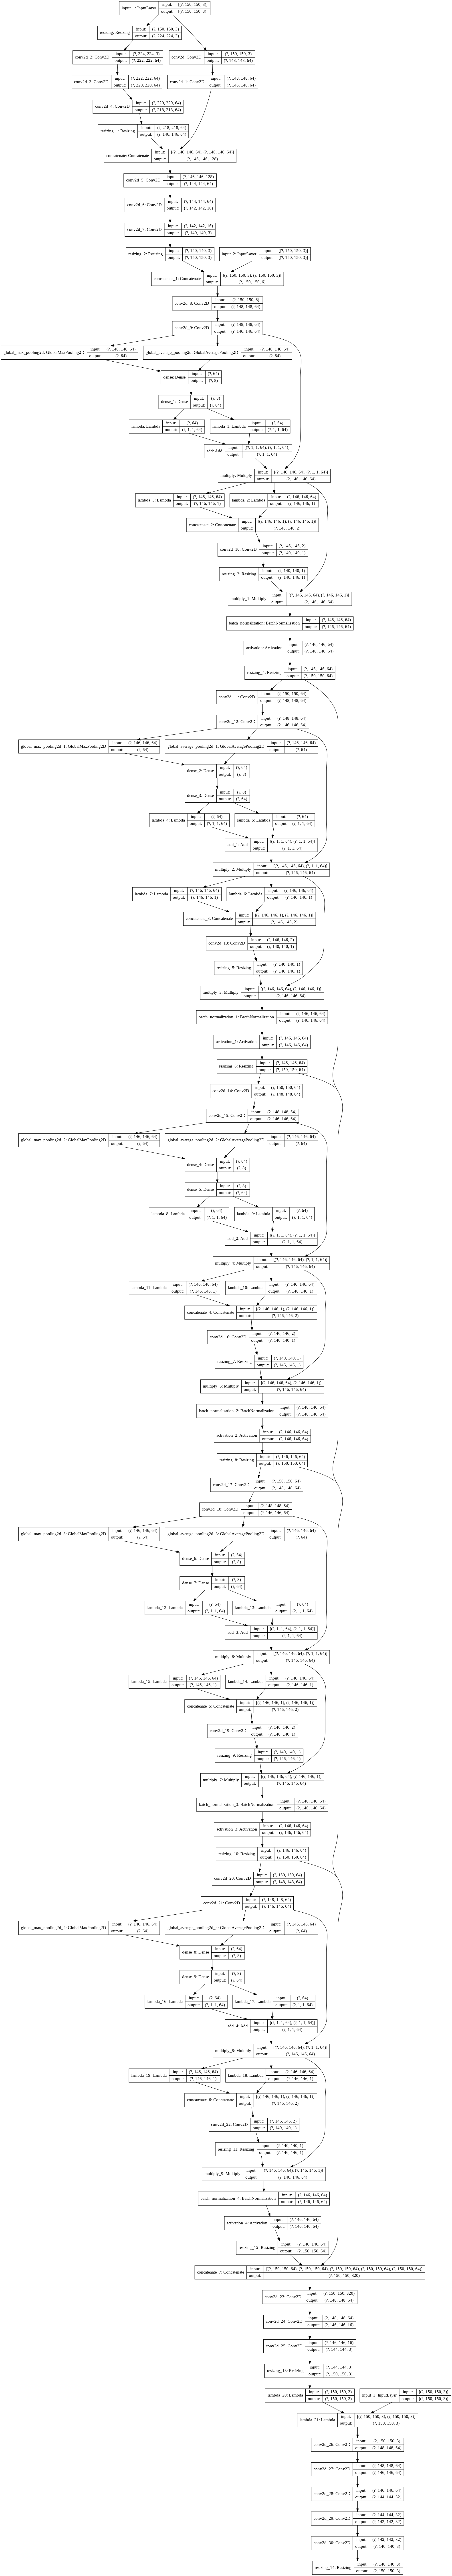

In [93]:
keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

# Model Compile

In [94]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),loss=custom_loss_wrapper(input_layer_1),metrics=[keras.metrics.MSE])

In [95]:

img_high.shape

(1485, 150, 150, 3)

# Model Fitting

In [97]:
model.fit(x=[img_low,img_low,img_low],y=img_high,epochs=1,batch_size=28)

29/54 [===============>..............] - ETA: 28s - loss: 1.5204 - mean_squared_error: 25252922916864.0000

KeyboardInterrupt: ignored